<a href="https://colab.research.google.com/github/viridis45/Python-data-analysis/blob/master/20190828_6_%ED%85%8D%EC%8A%A4%ED%8A%B8%EC%99%80_%EC%8B%9C%ED%80%80%EC%8A%A4%EB%A5%BC_%EC%9C%84%ED%95%9C_%EB%94%A5%EB%9F%AC%EB%8B%9D(2_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

순환 신경망의 사용법
- 기상 데이터 사용하기
- Recurrent Dropoup (순환드롭아웃): prevents overfitting
- Stacking Recurrent Layer : increases representational power but takes up much computing power
- Bidirectional Recurrent Layer : self explanatory. enhances accuracy, 기억 오래 유지


In [0]:
from google.colab import drive
drive.mount('/content/drive')

# By hand


## 데이터 둘러보기

In [21]:
data_dir = '/content/drive/My Drive/study/CS/ai/data/jena_climate_2009_2016.csv'
#data_dir = './data/jena_climate_2009_2016.csv'
f = open(data_dir)

#reading csv w/o pandas yay
data = f.read()
f.close()
lines = data.split('\n') # csv -- sep by , and newline
header = lines[0].split(',')
lines = lines[1:] #take out the header and rest is the body

print(len(lines))
print(len(header))
print(header)


import numpy as np
float_data = np.zeros((len(lines), len(header) -1)) #creating the empty dimension

for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]] # the first element in a line is datetime. taking it out. now i know y len(header)-1
  float_data[i,:] = values # writing the values onto the empty dimension
  

  
from matplotlib import pyplot as plt
temp = float_data[:,1] # == "T (degC)"
# plt.plot(range(len(temp)), temp)
# plt.plot(range(1440), temp[:1440]) #처음 10일간의 온도 데이터. 10분마다 데이터 기록 -> 10*6*24*10 = 1440

420551
15
['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


strategy:
- x 일 전의 데이터를 가져와 y increment 만큼씩 샘플링, z 시간 이후의 온도 예측
- x : lookback, 10일 전 == 1440
- y : stpes, 1시간마다 샘플링 == 6
- z : delay, 24시간 이후의 온도 예측 == 144

시계열 특성의 범위가 다르므로 전처리 필요 (온도, 습도 등 개별 정규화)

generator를 이용하여 필요한 정보 빼내기


## 정규화

In [0]:
# 20만개 데이터만 사용합니다


mean = float_data[:200000].mean(axis=0)
float_data -= mean # normalization, by subtracting the mean
std = float_data[:200000].std(axis=0)
float_data /= std # standardization, by dividing by std


## 데이터 떼오는 '제너레이터' 만들기

In [0]:
# delay = 타켓용 미래의 타임샘플
# lookback : 입력용 배치사이즈


def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1 # maxindex 가 정해지지 않았을 경우 미래에셋뺀것을 맥스인덱스로
 

  i = min_index + lookback # 룩백수만큼 떼오기. 이거 맥스인덱스넘버값인듯
  while 1:
    if shuffle:
      rows = np.random.randint( min_index + lookback, max_index, size=batch_size) # 랜덤하게 배치사이즈개 뽑아내기
      
    else:
      if i+batch_size >= max_index: # 떼온 시간값이 최대시간값을 넘긴 경우
        i = min_index + lookback # but you've decleared it already why again
      rows = np.arange(i, min(i+batch_size, max_index)) #랜덤뽑기가 싫은 경우 배치사이즈만큼 뽑아내기. 맥스인덱스를 최대뽑힐수있는값으로 제한해주기
      # 그런데 i값 내에서 쓰지 않고 한 배치 엑스트라를 줍니다 왜?
      i += len(rows) 
      
    samples = np.zeros((len(rows), lookback//step, data.shape[-1])) #배치만큼 자리맹길기
    targets = np.zeros((len(rows), ))

    for j,row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
      
    yield samples, targets # wait why not return is it because of while
  

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback = lookback, delay = delay, 
                      min_index = 0, max_index = 200000, shuffle=True, step = step, batch_size = batch_size)

val_gen = generator(float_data, lookback = lookback, delay = delay, 
                      min_index = 200001, max_index = 300000, shuffle=True, step = step, batch_size = batch_size)

test_gen = generator(float_data, lookback = lookback, delay = delay, 
                      min_index = 300001, max_index = None, shuffle=True, step = step, batch_size = batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_stepa = (len(float_data) - 300001 - lookback) // batch_size


In [39]:
#np.mean(np.abs(preds - targets))

def evaluate_naive_method ():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
    
  print(np.mean(batch_maes))
  return np.mean(batch_maes)
  
  
celcius_mae = float(evaluate_naive_method()) * std[1]
print(celcius_mae)

0.289617159976239
2.563835642880364


# By ML

## 모델 만들기
회귀문제이므로 dense에 활성화함수가 없음


In [44]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch = 500, epochs = 20, validation_data = val_gen, validation_steps=val_steps)

W0829 02:58:27.506194 140528603277184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0829 02:58:27.695552 140528603277184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0829 02:58:27.703026 140528603277184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/20
500/500 [==============================] - 16s 32ms/step - loss: 1.3061 - val_loss: 0.6006
Epoch 2/20
500/500 [==============================] - 16s 32ms/step - loss: 0.4842 - val_loss: 0.3795
Epoch 3/20
500/500 [==============================] - 16s 32ms/step - loss: 0.3093 - val_loss: 0.3186
Epoch 4/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2748 - val_loss: 0.3131
Epoch 5/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2595 - val_loss: 0.3392
Epoch 6/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2496 - val_loss: 0.3575
Epoch 7/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2408 - val_loss: 0.3686
Epoch 8/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2349 - val_loss: 0.3259
Epoch 9/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2309 - val_loss: 0.3346
Epoch 10/20
500/500 [==============================] - 16s 32ms/step - loss: 0.225

##막간을 이용한 케라스의 세 가지 모델 트레이닝법 리뷰
.fit
.fit_generator
.train_on_batch

all returns history obj

: record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable).

fit:

fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1)
- entire training set will be fit into RAM
- provided data will be used as is -- no manipulation of it will be performed in between
- no need moving batches of data in and out of RAM


fit_generator:

- when the data needs to be processed first
- model.fit_generator(somefunction.flow(trainX, trainY, batch_size=stm ),
	validation_data=(testX, testY), steps_per_epoch = len(trainX) // stm,
	epochs=stme)
- somefunction manipulates the data. ex) image manipulation
- batch_size feeds stm만큼씩
- steps_per_epoch : so this fit_generator actually takes a generator function i.e. infinite loop. why designed like this idk but therefore need something that will stop the somefunction. somefunction will run len(trainX)//stm times. and fit_generator will run stme times.


train_on_batch

train_on_batch(x, y, sample_weight=None, class_weight=None)
- finr-grade control.
- for training on one explicit batch of data
- allows to control weight





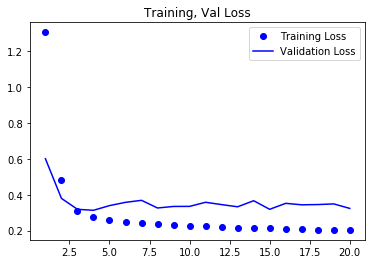

In [45]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training, Val Loss')
plt.legend()
plt.show()

## 순환 신경망 이용하기
위의 완전 연결 네트워크는 시계열 데이터를 펼쳐놓았기에 시간개념 손실.

인과관계와 순서를 중시하는 시퀀스를 사용해보자

LSTM / GRU

LSTM은 정교하지만 computationally expensive and complex.

trying GRU

W0829 05:01:07.426043 140528603277184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
500/500 [==============================] - 97s 195ms/step - loss: 0.3046 - val_loss: 0.2692
Epoch 2/20
500/500 [==============================] - 97s 193ms/step - loss: 0.2817 - val_loss: 0.2721
Epoch 3/20
500/500 [==============================] - 97s 195ms/step - loss: 0.2759 - val_loss: 0.2697
Epoch 4/20
500/500 [==============================] - 97s 195ms/step - loss: 0.2708 - val_loss: 0.2739
Epoch 5/20
500/500 [==============================] - 97s 194ms/step - loss: 0.2683 - val_loss: 0.2679
Epoch 6/20
500/500 [==============================] - 97s 193ms/step - loss: 0.2642 - val_loss: 0.2706
Epoch 7/20
500/500 [==============================] - 97s 193ms/step - loss: 0.2585 - val_loss: 0.2732
Epoch 8/20
500/500 [==============================] - 96s 192ms/step - loss: 0.2579 - val_loss: 0.2737
Epoch 9/20
500/500 [==============================] - 96s 192ms/step - loss: 0.2503 - val_loss: 0.2694
Epoch 10/20
500/500 [==============================] - 97s 194ms/step - l

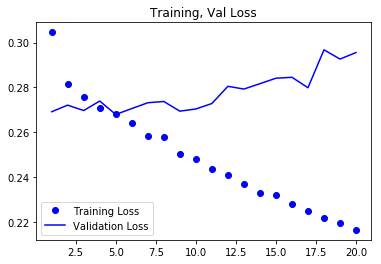

In [52]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch = 500, epochs = 20, validation_data = val_gen, validation_steps = val_steps)


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training, Val Loss')
plt.legend()
plt.show()